# Import dependencies

In [1]:
from matplotlib import pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import scipy
from scipy.stats import probplot, chi2_contingency, spearmanr
import seaborn as sns
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, KFold, cross_val_predict, learning_curve
from sklearn.metrics import f1_score, classification_report, make_scorer, precision_score, recall_score, r2_score, mean_absolute_error, mean_squared_error, precision_recall_curve, auc
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
import statsmodels.api as sm
from sklearn.linear_model import Lasso, LinearRegression, LogisticRegression, Ridge
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer

# Predicting annual net balance

**Aim:** "Build supervised machine learning model(s) to predict annual net savings based on other variables. Include appropriate safeguards against overfitting. Comment on the results. How well do the models perform? Is the performance stable? Are the models interpretable / explainable? Are these models suitable for decision-making? Is there enough signal in the data to build good models? Is there anything suspicious about the results?"

## Summary

Due to time constraints, predictive models are only developed to predict annual savings above zero. Two models were created.
  
* A ridge regression model was implemented, incorporating an additional L2 regularisation term to counteract overfitting. Given that the ordinary least squares model fitted the data very well, the same features were used.

* A random forest model was tested as it can handle increased model complexity without requiring the additional interaction terms (which can lead to overfitting in regression models).
 
**1) How well do the models perform?**

* Both models demonstrated high performance, characterised by elevated R-squared values and normal residuals. Moreover, learning curves did not reveal significant overfitting.

**2) Is the performance stable?**

* To assess stability, five-fold cross-validation was employed for the optimised models. The results indicate that both models exhibit reasonable stability.

**3) Are the models interpretable / explainable?**

* The ridge regression model is more easily interpreted than the random forest model. While feature importance during the training process can be determined for random forests, the coefficients in ridge regression are readily available and more easily interpreted.

    Note: Due to the additional regularisation term, the ridge regression model likely exhibits lower variance than the ordinary least squares model at the cost of increased bias in the coefficient estimates.

**4) Are these models suitable for decision-making? Is there enough signal in the data to build good models?**

* Although the predictive performance of these models is high, it's important to note they are only applicable to individuals with annual savings above zero. Before utilising these models for decision-making, it might be necessary to develop a model predicting the probability of non-zero savings. Preliminary work in the econometrics workbook suggested that there might not be enough signal in the data for this latter task. Future work should involve testing non-linear models on this particular challenge and/or collecting more data.

## Import cleaned data

In [2]:
# Training data
clean_train_df = pd.read_csv('../data/cleaned/clean_train.csv')
print(f"Number of rows: {clean_train_df.shape[0]}")
print(f"Number of columns: {clean_train_df.shape[1]}")
clean_train_df.head(5)

Number of rows: 23392
Number of columns: 15


,cust_unique_id,age,gender,ethnicity_group,geo_region,net_salary,observed_income,childcare_spend,gambling_spend,observed_surplus,credit_score,savings_bal_lbg,annual_net_savings_lbg,other_income,housing_spend
0,12711,40,F,White British,Southwest,45385.08,52337.85,0.0,757.12,33385.24,1522.26,477383.97,0.00,6952.77,18195.490
1,11308,22,M,South Asian,Scotland,47307.51,57734.58,0.0,0.00,34201.97,1563.66,0.00,0.00,10427.06,23532.610
2,29607,32,M,White British,Southwest,54393.92,64505.17,0.0,0.00,64505.17,1708.02,271540.82,19258.84,10111.26,21109.689
3,17150,27,Other,White British,Scotland,46380.41,55337.96,0.0,0.00,55337.96,1620.99,65397.27,16928.97,8957.56,23471.349
4,28362,34,M,White British,Southeast,68217.27,86613.91,0.0,0.00,60559.66,2140.43,535651.79,24985.39,18396.64,26054.250


In [3]:
# Test data
clean_test_df = pd.read_csv('../data/cleaned/clean_test.csv')
print(f"Number of rows: {clean_test_df.shape[0]}")
print(f"Number of columns: {clean_test_df.shape[1]}")
clean_train_df.head(5)

Number of rows: 5862
Number of columns: 15


,cust_unique_id,age,gender,ethnicity_group,geo_region,net_salary,observed_income,childcare_spend,gambling_spend,observed_surplus,credit_score,savings_bal_lbg,annual_net_savings_lbg,other_income,housing_spend
0,12711,40,F,White British,Southwest,45385.08,52337.85,0.0,757.12,33385.24,1522.26,477383.97,0.00,6952.77,18195.490
1,11308,22,M,South Asian,Scotland,47307.51,57734.58,0.0,0.00,34201.97,1563.66,0.00,0.00,10427.06,23532.610
2,29607,32,M,White British,Southwest,54393.92,64505.17,0.0,0.00,64505.17,1708.02,271540.82,19258.84,10111.26,21109.689
3,17150,27,Other,White British,Scotland,46380.41,55337.96,0.0,0.00,55337.96,1620.99,65397.27,16928.97,8957.56,23471.349
4,28362,34,M,White British,Southeast,68217.27,86613.91,0.0,0.00,60559.66,2140.43,535651.79,24985.39,18396.64,26054.250


In [4]:
# Update cust_unique_id -> categorical dtype
clean_train_df['cust_unique_id'] = pd.Categorical(
    clean_train_df['cust_unique_id'], list(clean_train_df['cust_unique_id'].unique()), ordered=True
)
clean_test_df['cust_unique_id'] = pd.Categorical(
    clean_test_df['cust_unique_id'], list(clean_test_df['cust_unique_id'].unique()), ordered=True
)

In [5]:
print(f'\n-----------------------------Training set-----------------------------\n')
display(clean_train_df.info())
print(f'\n-----------------------------Test set-----------------------------\n')
display(clean_train_df.info())


-----------------------------Training set-----------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23392 entries, 0 to 23391
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   cust_unique_id          23392 non-null  category
 1   age                     23392 non-null  int64   
 2   gender                  23392 non-null  object  
 3   ethnicity_group         23392 non-null  object  
 4   geo_region              23392 non-null  object  
 5   net_salary              23392 non-null  float64 
 6   observed_income         23392 non-null  float64 
 7   childcare_spend         23392 non-null  float64 
 8   gambling_spend          23392 non-null  float64 
 9   observed_surplus        23392 non-null  float64 
 10  credit_score            23392 non-null  float64 
 11  savings_bal_lbg         23392 non-null  float64 
 12  annual_net_savings_lbg  23392 non-null  float64 
 13  oth

None


-----------------------------Test set-----------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23392 entries, 0 to 23391
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   cust_unique_id          23392 non-null  category
 1   age                     23392 non-null  int64   
 2   gender                  23392 non-null  object  
 3   ethnicity_group         23392 non-null  object  
 4   geo_region              23392 non-null  object  
 5   net_salary              23392 non-null  float64 
 6   observed_income         23392 non-null  float64 
 7   childcare_spend         23392 non-null  float64 
 8   gambling_spend          23392 non-null  float64 
 9   observed_surplus        23392 non-null  float64 
 10  credit_score            23392 non-null  float64 
 11  savings_bal_lbg         23392 non-null  float64 
 12  annual_net_savings_lbg  23392 non-null  float64 
 13  other_i

None

## Ridge Regression

### Background

#### Ridge regression

**1) Assumptions**

**_Linear data generating process_**

* The dependent variable is linearly dependent on the predictive variables (i.e. coefficients all raised to the power of one)

    $Y = b_0 + b_1X_1 + b_2X_2 + ... + b_pX_p + e$

    *Note: Linear regression models can model curvature by including nonlinear variables (e.g. $X_i^2$)*

**_Error_**

* The conditions are relaxed as the focus is on prediction

* A strong model will meet the below:

        * All independent variables are uncorrelated with the error term (AKA Exogeneity)
    
            Note: It leads to bias in the coefficient estimates. It can indicate a missing variable or measurement error.
    
        * The error term has a mean of zero
    
        * The error term has constant variance (aka homoskedasticity)
    
        * The error terms are not correlated across observations (i.e. no autocorrelation)
    
            Note: Autocorrelation indicates non-random error.
    
        * The residuals are normally distributed (OPTIONAL)
    
            Note: Required for unbiased estimates of standard error etc.

---------------------

**2) Overfitting**

**_Definition:_**

* Overfitting is a common issue in machine learning where a model learns the training data too well capturing noise

* This leads to poor generalisation

**_Ridge regression:_**

* The coefficients obtained from ridge regression are shrunken toward zero

* This results is less complex and less sensitive models, thereby reducing overfitting

---------------------

**2) Implementation**

**_Optimisation_**

* Ridge regression can be solved via two methods:

    1. ***Algebraically*** via the below closed form solution.
    
        $ W = (XX^T + \lambda I)^{-1}Xy^T $
        
        Where, I is the identity matrix
    
    2. ***Iteratively*** using the gradient descent algorithm to estimate parameter coefficients.

**_Objective function_**

* MSE cost function + squared-L2-norm:

    $ \min_{w} \frac{1}{N}\sum_{i=1}^N (y_i - \hat{y}_i)^2 + \lambda||W||_2^2 $ 
    
    $ \min_{w} \frac{1}{N}\sum_{i=1}^N (y_i - \sum_{j=0}^d w_j x_j)^2 + \lambda \left(\sqrt{\sum_{j=1}^d |w_j|^2}\right)^2$ 
    
    $ \min_{w} \frac{1}{N}\sum_{i=1}^N (y_i - \sum_{j=0}^d w_j x_j)^2 + \lambda \sum_{j=1}^d |w_j|^2$ 

    *Where, lambda is the tuning parameter (larger values result in stronger regularization), N is the number of training samples, W is the d-dimensional vector of model parameters (i.e. weights), which includes a dummy variable x<sub>0</sub>=1 for the y-intercept.*

    Note: In practice, the cost function often uses 1/2N to simplify implementation.

**_L2-regularisation_**

* The *squared* L2-norm is used to penalise model complexity

* The L2 term is a function of the number and size of the coefficients. It is equivalent to Euclidian distance:

    $ ||W||_2 = \sqrt{\sum_{j=1}^d w_j^2} $
    
    *Where, W is the d-dimensional vector of model parameters (i.e. weights), which includes a dummy variable x<sub>0</sub>=1 for the y-intercept.*

*Properties:*

* The L2-norm squares the individual model parameters. This means large weights are much more influential than smaller weights. Compared to L1 regularisation, L2 therefore prioritises minimising larger weights

* In practice regularisation is achieved by keeping the magnitude of the weight vector below a threshold (e.g. 1)

    $\sum_{j=1}^d w_j^2 \leq 1 $

    E.g. $|w_1|^2 + |w_2|^2 < 1$

* The area in which the optimal weight vector resides will therefore take the shape of a circle centred on the origin

    <img src="figures/l1_l2_constraint.png" align="center" width="250" /> <img src="figures/l2_surface.png" align="center" width="350" />

* If gradient descent is used to optimise weights, L2 is less likely to to reduce coefficients to zero than L1 regularisation.

* Why? The cost surface is smoother. Also, the gradient decreases as weights approach zero in magnitude. This slows the rate at which a weight decreases in value. 

* L2 therefore tends lead to weights with similar sizes. Although weights can get very very small, L2 is less likely to reduce coefficients to zero.

---------------------

**3) Interpretation**

* Ridge regression results in biased estimates of coefficients

* Coefficients reflect the relationship between the independent variables and the dependent variable *after regularisation*

* Implication:

    - Absolute magnitudes does not directly represent variable importance
      
    - It's difficult to compare models with a different magnitude regularization parameter

---------------------

#### Assessing overfitting

* 5-fold cross validation is used to assess overfitting as a function of dataset size

* A larger dataset provides more diverse examples, models are likely to capture patterns that are more consistent and less sensitive to noise or outliers

**_Confidence intervals_**

    "Confidence intervals define the interval which has a 0.95 probability of containing the true parameter"

    "the long run proportion of sample confidence intervals which will contain a true parameter"

* Ridge regression outputs a point estimate of MSE

* This will vary from sample-to-sample

* The confidence interval quantifies the uncertainty

**_1. Bootstrap estimate_**

* Estimate sampling distribution by bootstrapping (sampling w. replacement) & fitting multiple times

* Confidence interval encloses the relevant % of the sampling distribution

**_2. t-score_**

* Compute MSE

    $MSE = \sum_{i=1}^n\bigl(y_i - \hat{y_i}\bigr)^2$

* Determine dof for t-distribution

  $df_{residual} = n - df_{model} = n- p - 1$

    *Model parameters are estimates and therefore introduce constraints on variability of residuals*

* Choose a confidence level

* Estimate the standard error

    $SE = \frac{s}{\sqrt{n}}$

    *Use the standard deviation of the squared residuals*

* Compute critical t statistic value for the given confidence level

  *This will depend on the degrees of freedom*
 
* Compute margin of error

  $Margin = S.E \times t_{critical}$

* Construct confidence interval

    $CI = MSE \pm margin$

---------------------

### Feature preprocessing
* Given the good fit exhibited by the prior ordinary least squares model, the same feature engineering steps are conducted.

    Note: Additional min-max scaling is conducted so no variable dominates optimisation.

In [6]:
# Filter out zero values
clean_train_df = clean_train_df.loc[clean_train_df['annual_net_savings_lbg']!=0].reset_index(drop=True)
clean_test_df = clean_test_df.loc[clean_test_df['annual_net_savings_lbg']!=0].reset_index(drop=True)

In [7]:
def preprocess_ridge_features(df):
    """
    Remove selected features and apply required feature engineering steps.
    """
    # Drop selected features
    df = df.drop(['net_salary', 'observed_income', 'other_income', 'cust_unique_id', 'gambling_spend'], axis=1)

    # Add breakpoint dummy variables for age
    df['age_dummy_1'] = np.where(df['age'] < 25, 1, 0)
    df['age_dummy_2'] = np.where((df['age'] >= 25) & (df['age'] < 55), 1, 0)
    df['age_dummy_3'] = np.where(df['age'] >= 55, 1, 0)

    # Add interaction terms for age
    df['age_interaction_1'] = df['age_dummy_1'] * df['age']
    df['age_interaction_2'] = df['age_dummy_2'] * df['age']
    df['age_interaction_3'] = df['age_dummy_3'] * df['age']

    # Add breakpoint dummy variable for savings_bal_lbg
    df['savings_bal_dummy'] = np.where(df['savings_bal_lbg'] > 2e6, 1, 0)

    # Add interaction term for savings_bal_lbg
    df['savings_bal_interaction'] = df['savings_bal_dummy'] * df['savings_bal_lbg']

    # Add dummy variable for predictive features with a high proportion of zeros
    df['zero_savings_bal'] = (df['savings_bal_lbg'] == 0).astype(int)
    df['zero_childcare_spend'] = (df['childcare_spend'] == 0).astype(int)

    # Divide predictive features from target
    y_train = df['annual_net_savings_lbg']
    X_train = df.drop(['annual_net_savings_lbg'], axis=1)

    # One-hot-encode the categorical features
    for col in ['gender', 'geo_region', 'ethnicity_group']:
        X_train = pd.get_dummies(X_train, columns=[col], prefix=col, dtype='int64', drop_first=True)

    return X_train, y_train

In [8]:
# Preprocess features
X_train, y_train = preprocess_ridge_features(clean_train_df)

In [9]:
# Drop features with insignificant p-values in OLS
features_to_drop = ['childcare_spend', 'observed_surplus', 'age_dummy_1', 'savings_bal_dummy', 'zero_childcare_spend',
                    'gender_F', 'gender_M', 'gender_Other', 'geo_region_North', 'geo_region_Scotland', 'geo_region_Southeast',
                    'geo_region_Southwest', 'geo_region_Wales', 'ethnicity_group_Other', 'ethnicity_group_White British',
                    'ethnicity_group_White Other']
X_train = X_train.drop(features_to_drop, axis=1)

### Pipeline

In [10]:
# Create Ridge regression pipeline
categorical_features = X_train.select_dtypes('object').columns
continuous_features = X_train.select_dtypes('number').columns

ridge_preprocessor = ColumnTransformer(
    transformers=[('scaler', MinMaxScaler(), continuous_features),
                  ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical_features)],
    remainder='passthrough'
)
ridge_pipeline = Pipeline([
    ('preprocessor', ridge_preprocessor),
    ('ridge', Ridge(max_iter=10000, random_state=42))]
                   )

### Hyperparameter optimisation
* Five-fold cross validation gridsearches are used to optimise the strength of the regularisation parameter.

In [11]:
# Cross-validated grid search
ridge_param_grid = {'ridge__alpha': [0.001, 0.01, 0.1]}
ridge_grid_search = GridSearchCV(
    ridge_pipeline, ridge_param_grid, cv=5, scoring='neg_mean_squared_error'
)
ridge_grid_search.fit(
    X_train, y_train
)

# Access the best model's attributes
ridge_best_model = ridge_grid_search.best_estimator_
ridge_best_params = ridge_grid_search.best_params_
ridge_best_score = ridge_grid_search.best_score_
print(ridge_best_score)
print(ridge_best_params)

-3333288.7178949923
{'ridge__alpha': 0.1}


### Evaluation

**Learning curve**
* A learning curve is plotted for the optimal model. This reveals no overfitting.

In [12]:
# Update pipeline
ridge_pipeline = Pipeline([
    ('preprocessor', ridge_preprocessor),
    ('ridge', Ridge(max_iter=10000, alpha=0.01, random_state=42))]
)

# Create a learning curve
train_sizes, train_scores, valid_scores = learning_curve(
    ridge_pipeline, X_train, y_train, train_sizes=[0.1, 0.25, 0.5, 0.75, 1.0], cv=5, scoring='neg_mean_squared_error', random_state=42
)

# Calculate score means and standard deviations
train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = -np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

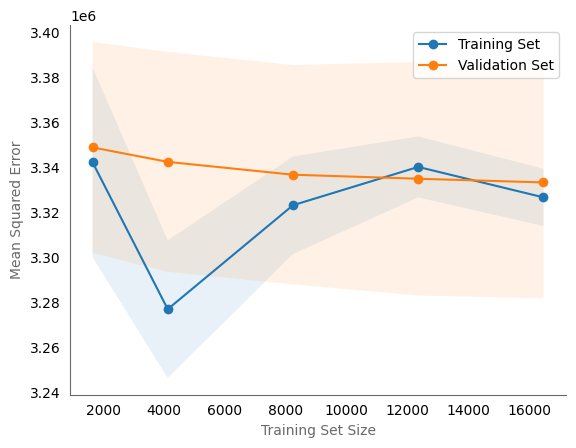

In [13]:
# Plot the learning curve with confidence intervals
fig, axes = plt.subplots(
    figsize=(6.4, 4.8)
)
axes.tick_params(bottom=False, left=False)
axes.grid(False)
axes.spines[['top', 'right']].set_visible(False)
axes.spines[['left', 'bottom']].set_color('dimgray')

axes.plot(train_sizes, train_scores_mean, label='Training Set', marker='o')
axes.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1)
axes.plot(train_sizes, valid_scores_mean, label='Validation Set', marker='o')
axes.fill_between(train_sizes, valid_scores_mean - valid_scores_std, valid_scores_mean + valid_scores_std, alpha=0.1)
axes.set_xlabel('Training Set Size', fontsize=10, color='dimgray')
axes.set_ylabel('Mean Squared Error', fontsize=10, color='dimgray')
axes.legend();

**Predictive performance**
* The stability of the optimal model is assessed using 5-fold cross validation. No significant deviations in R-squared or the normality of residuals is observed between folds.

R^2: 0.923 +/- 0.002
MAE: 1455.257 +/- 16.36
RMSE: 1825.526 +/- 70650.266


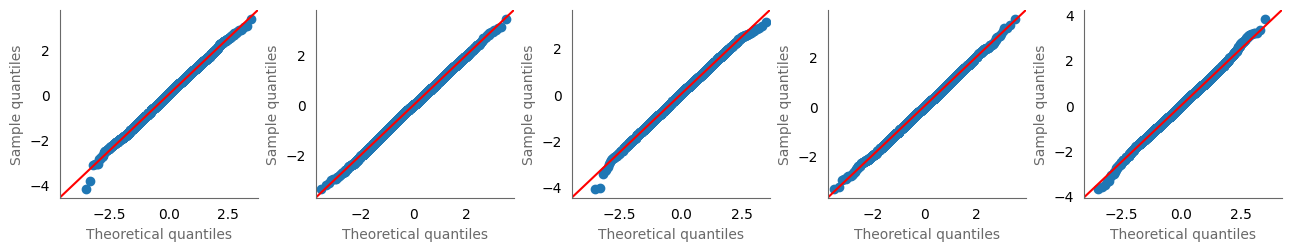

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=5, constrained_layout=True, figsize=(6.4*2, 4.8/2))
cv = KFold(n_splits=5, shuffle=True, random_state=42)

r2, mae, rmse = [], [], []

for i, (train_index, test_index) in enumerate(cv.split(X_train, y_train)):
    X_train_k, y_train_k = X_train.iloc[train_index], y_train.iloc[train_index]
    X_test_k, y_test_k = X_train.iloc[test_index], y_train.iloc[test_index]

    ridge_pipeline.fit(X_train_k, y_train_k)
    y_pred_k = ridge_pipeline.predict(X_test_k)

    r2.append(r2_score(y_test_k, y_pred_k))
    mae.append(mean_absolute_error(y_test_k, y_pred_k))
    rmse.append(mean_squared_error(y_test_k, y_pred_k))

    residuals = y_test_k - y_pred_k
    standardised_residuals = residuals / np.std(residuals)

    sm.qqplot(
        standardised_residuals, line='45', ax=axes[i]
    )
    axes[i].set_xlabel('Theoretical quantiles', fontsize=10, color='dimgray')
    axes[i].set_ylabel('Sample quantiles', fontsize=10, color='dimgray');

for ax in axes:
    ax.tick_params(bottom=False, left=False)
    ax.grid(False)
    ax.spines[['top', 'right']].set_visible(False)
    ax.spines[['left', 'bottom']].set_color('dimgray')

print(f"R^2: {round(np.mean(r2), 3)} +/- {round(np.std(r2), 3)}")
print(f"MAE: {round(np.mean(mae), 3)} +/- {round(np.std(mae), 3)}")
print(f"RMSE: {round(np.sqrt(np.mean(rmse)), 3)} +/- {round(np.std(rmse), 3)}")

## Random Forest

### Background

#### Random forest

**1) Properties**

* A non-linear model

* Makes a prediction using a collection of decision trees

* Advantages:

    1. Higher accuracy (lower variance) than individual decision tree
    
    2. Generalisation error can be estimated using the data left out of the bootstrapped training set for each tree (AKA out-of-bag estimates)
    
    3. Feature importance can be compared by ranking their mean decrease in variance/Gini impurity/entropy across all trees

* Disadvantages:
    1. Sacrifice some explainability

-----------------

**2) Assumptions**

* Non-parametric

* No transformation or scaling of predictive features is required

    *any monotonic transformation wont affect ranks in the features*

-----------------

**3) Implementation**

**_Splitting criterion_**

* The choice of split values is based on minimizing target variable variance:

    $Var(Y) = E[(Y-\mu)^2]$

* The total node variance is a weighted sum of the variances of the child nodes

**_Algorithm_**

1. Initialise $M$ decision trees to be fit.

2. Take a bootstrap resample (w. replacement) from the training data
   
3. Randomly sample $p$ variables ($p=\sqrt{P}$) (without replacement)

4. For each variable:

    - Iterate over all values, splitting the training data into two subpartitions

    - Select the split value that maximises subpartition homogeneity

5. Select the variable (& corresponding split value) that maximises subpartition homogeneity

6. Repeat steps $2-4$ for subsequent subpartitions

7. Terminate when no further partition can sufficiently improve homogeneity

8. Increment the model counter $m$ by one. If $m\leq M$, repeat.

**_Making predictions_**

* For classification problems, majority voting is used to decide class.

* For regression problems, the bagged estimate is given by: 

    $\hat{f}(X)=\frac{1}{M} (\hat{f}_2(X) + \hat{f}_2(X)+...+ \hat{f}_M(X))$

  *Where M is the number of decision trees*

-----------------

**4) Interpretation**

**_Out-of-bag estimates_**

* Collected during training

* Enable assessment of generalisation error

* *How?*

    - Predictions are made for the samples not included in the bootstrap sample ($\sim 1/3$)

      *For regression problems, predictions are averaged. While for classification, a majority vote is used.*
 
    - An OOB score is then calculated

**_Feature importance_**

* Assessed during training

* How?

    - Cumulatively track the total reduction in impurity/variance due to a feature across all trees
 
    - After all trees are built, the cumulative scores are normalized so they sum to $1$
 
    - The normalised scores indicate the relative importance of each feature

------------------

**5) Overfitting**

* Overfitting is where a model learns the training data too well capturing noise. It leads to poor generalisation.

**_Random forest algorithm_**

* Addresses overfitting by introducing randomness & averaging predictions:

    1. Each tree is trained using a different version of the training data
      
    2. Each node considers a random subset of variables
 
    3. The final prediction is obtained by averaging the predictions
 
       *reduces the impact of outliers or noise that may be captured by individual trees.*

**_Hyperparameter optimisation_**

1. min samples leaf -- minimum size for terminal nodes (leaves in the tree)
   
2. max leaf nodes -- linked to the maximum number of nodes in each decision tree via:
   
    $\text{max nodes} = 2 (\text{max leaf nodes})-1$

**_Dataset size_**

* A larger dataset provides more diverse examples
  
* Models are likely to capture patterns that are more consistent and less sensitive to noise or outliers

--------------------------

#### Assessing overfitting

* 5-fold cross validation is used to assess overfitting as a function of dataset size

**_Confidence intervals_**

    "Confidence intervals define the interval which has a 0.95 probability of containing the true parameter"

    "the long run proportion of sample confidence intervals which will contain a true parameter"

* Random forest outputs a point estimate of MSE

* This will vary from sample-to-sample

* The confidence interval quantifies the uncertainty

**_1. Bootstrap estimate_**

* Estimate sampling distribution by bootstrapping (sampling w. replacement) & fitting multiple times

* Confidence interval encloses the relevant % of the sampling distribution

**_2. t-score_**

* Compute MSE

    $MSE = \sum_{i=1}^n\bigl(y_i - \hat{y_i}\bigr)^2$

* Determine dof for t-distribution

  $df_{residual} = n - df_{model} = n- p - 1$

    *Model parameters are estimates and therefore introduce constraints on variability of residuals*

* Choose a confidence level

* Estimate the standard error

    $SE = \frac{s}{\sqrt{n}}$

    *Use the standard deviation of the squared residuals*

* Compute critical t statistic value for the given confidence level

  *This will depend on the degrees of freedom*
 
* Compute margin of error

  $Margin = S.E \times t_{critical}$

* Construct confidence interval

    $CI = MSE \pm margin$

---------------------

### Feature preprocessing
* Random forests can capture more complex relationships. Consequently, the interaction terms used earlier are dropped.
  
  Note: Min-max scaling is still conducted (although random forests are more robust than ridge regression in this regard).

In [15]:
def preprocess_rf_features(df):
    """
    Remove selected features and apply required feature engineering steps.
    """
    # Drop selected features
    df = df.drop(['net_salary', 'observed_income', 'other_income', 'cust_unique_id', 'gambling_spend'], axis=1)

    # Divide predictive features from target
    y_train = df['annual_net_savings_lbg']
    X_train = df.drop(['annual_net_savings_lbg'], axis=1)

    return X_train, y_train

In [16]:
# Preprocess features
X_train, y_train = preprocess_rf_features(clean_train_df)

### Pipeline

In [17]:
# Create random forest regression pipeline
categorical_features = X_train.select_dtypes('object').columns
continuous_features = X_train.select_dtypes('number').columns

rf_preprocessor = ColumnTransformer(
    transformers=[('scaler', MinMaxScaler(), continuous_features),
                  ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical_features)],
    remainder='passthrough'
)
rf_pipeline = Pipeline([
    ('preprocessor', rf_preprocessor),
    ('rf',RandomForestRegressor(random_state=42))]
                   )

### Hyperparameter optimisation

**1) Optimise min_samples_leaf & max_leaf_nodes**

* A five-fold cross validation gridsearch is used to optimise the complexity of constituent decision trees.

In [18]:
# Cross-validated grid search
rf_param_grid = {
    'rf__n_estimators': [50],
    'rf__min_samples_leaf': [5, 10, 25], # minimum size of terminal nodes
    'rf__max_leaf_nodes': [100, 150, 200], # proportional to maximum number of terminal nodes
}
rf_grid_search = GridSearchCV(
    rf_pipeline, rf_param_grid, cv=5, scoring='neg_mean_squared_error'
)
rf_grid_search.fit(
    X_train, y_train
)

# Access the best model's attributes
best_rf_model = rf_grid_search.best_estimator_
best_rf_params = rf_grid_search.best_params_
best_rf_score = rf_grid_search.best_score_
print(best_rf_score)
print(best_rf_params)

-3443689.87497845
{'rf__max_leaf_nodes': 150, 'rf__min_samples_leaf': 10, 'rf__n_estimators': 50}


**2) Optimise no. of estimators**

* Variance should decrease as the number of trees is increased. Consequently, the optimum number of decision trees was decided by monitoring changes in out-of-bag score.

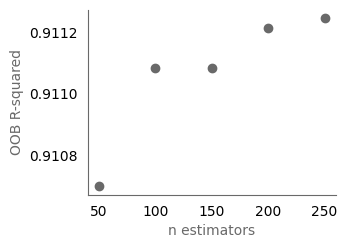

In [19]:
oob_scores = []
n_estimators = list(range(50, 300, 50))

for n in n_estimators:
    rf_pipeline = Pipeline(
        [('preprocessor', rf_preprocessor),
         ('rf', RandomForestRegressor(n_estimators=n, max_leaf_nodes=30, min_samples_leaf=100, oob_score=True, random_state=42))]
    )
    rf_pipeline.fit(X_train, y_train)
    oob_scores.append(
        rf_pipeline.named_steps['rf'].oob_score_
    )

# Plot oob_scores vs. number of trees
fig, axes = plt.subplots(
    nrows=1, ncols=1, figsize=(6.4/2, 4.8/2)
)
axes.scatter(
    n_estimators, oob_scores, color='dimgray', label='Pred'
)
axes.set_ylabel('OOB R-squared', fontsize=10, color='dimgray')
axes.set_xlabel('n estimators', fontsize=10, color='dimgray')
axes.tick_params(bottom=False, left=False)
axes.grid(False)
axes.spines[['top', 'right']].set_visible(False)
axes.spines[['left', 'bottom']].set_color('dimgray')

### Evaluation

**Learning curve**
* A learning curve is plotted for the optimal model. This reveals no substantial overfitting.

In [20]:
# Update pipeline
rf_pipeline = Pipeline([
    ('preprocessor', rf_preprocessor),
    ('rf', RandomForestRegressor(n_estimators=150, max_leaf_nodes=30, min_samples_leaf=100, oob_score=True, random_state=42))]
)

# Create a learning curve
train_sizes, train_scores, valid_scores = learning_curve(
    rf_pipeline, X_train, y_train, train_sizes=[0.1, 0.25, 0.5, 0.75, 1.0], cv=5, scoring='neg_mean_squared_error', random_state=42
)

# Calculate score means and standard deviations
train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = -np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

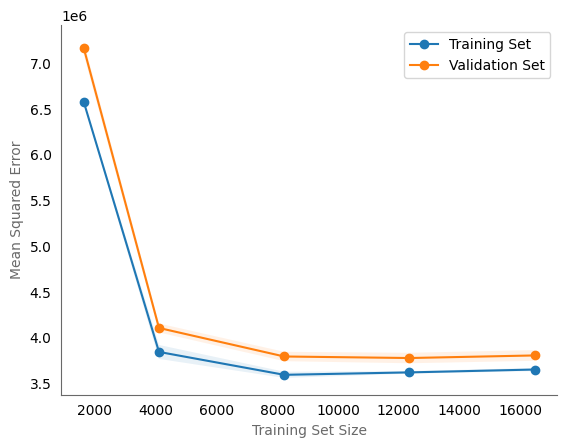

In [21]:
# Plot the learning curve with confidence intervals
fig, axes = plt.subplots(
    figsize=(6.4, 4.8)
)
axes.tick_params(bottom=False, left=False)
axes.grid(False)
axes.spines[['top', 'right']].set_visible(False)
axes.spines[['left', 'bottom']].set_color('dimgray')

axes.plot(train_sizes, train_scores_mean, label='Training Set', marker='o')
axes.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1)
axes.plot(train_sizes, valid_scores_mean, label='Validation Set', marker='o')
axes.fill_between(train_sizes, valid_scores_mean - valid_scores_std, valid_scores_mean + valid_scores_std, alpha=0.1)
axes.set_xlabel('Training Set Size', fontsize=10, color='dimgray')
axes.set_ylabel('Mean Squared Error', fontsize=10, color='dimgray')
axes.legend();

**Predictive performance**
* The stability of the optimal model is assessed using 5-fold cross validation. No significant deviations in R-squared or the normality of residuals is observed between folds.

R^2: 0.911 +/- 0.002
MAE: 1551.046 +/- 11.678
RMSE: 1954.19 +/- 75186.545


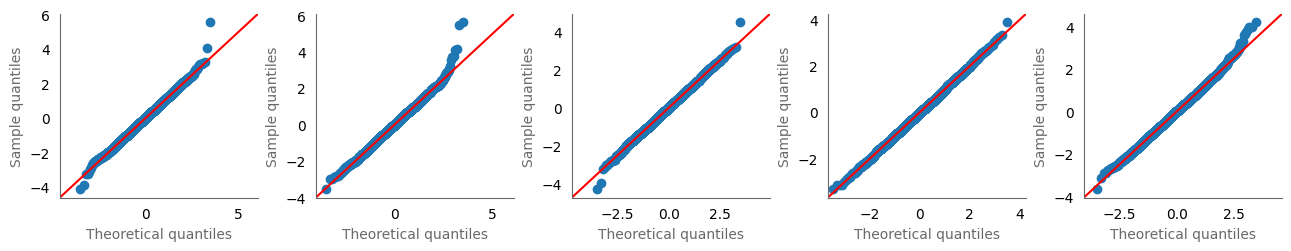

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=5, constrained_layout=True, figsize=(6.4*2, 4.8/2))
cv = KFold(n_splits=5, shuffle=True, random_state=42)

r2, mae, rmse = [], [], []

for i, (train_index, test_index) in enumerate(cv.split(X_train, y_train)):
    X_train_k, y_train_k = X_train.iloc[train_index], y_train.iloc[train_index]
    X_test_k, y_test_k = X_train.iloc[test_index], y_train.iloc[test_index]

    rf_pipeline.fit(X_train_k, y_train_k)
    y_pred_k = rf_pipeline.predict(X_test_k)

    r2.append(r2_score(y_test_k, y_pred_k))
    mae.append(mean_absolute_error(y_test_k, y_pred_k))
    rmse.append(mean_squared_error(y_test_k, y_pred_k))

    residuals = y_test_k - y_pred_k
    standardised_residuals = residuals / np.std(residuals)

    sm.qqplot(
        standardised_residuals, line='45', ax=axes[i]
    )
    axes[i].set_xlabel('Theoretical quantiles', fontsize=10, color='dimgray')
    axes[i].set_ylabel('Sample quantiles', fontsize=10, color='dimgray');

for ax in axes:
    ax.tick_params(bottom=False, left=False)
    ax.grid(False)
    ax.spines[['top', 'right']].set_visible(False)
    ax.spines[['left', 'bottom']].set_color('dimgray')

print(f"R^2: {round(np.mean(r2), 3)} +/- {round(np.std(r2), 3)}")
print(f"MAE: {round(np.mean(mae), 3)} +/- {round(np.std(mae), 3)}")
print(f"RMSE: {round(np.sqrt(np.mean(rmse)), 3)} +/- {round(np.std(rmse), 3)}")

## Final model

### Background

#### Goodness of fit

**_1. Pre-requisites_**
    
$RSS = \sum_{i=1}^n (y_i - \hat{y})^2$ *-> quantifies unexplained variability*

$TSS = \sum_{i=1}^n (y_i - \bar{y})^2$ *-> quantifies variability in dependent variable*

**_2. R-squared_**

$R^2 = 1 - \frac{RSS}{TSS}$

* $R^2=0$ *-> model predicts $\bar{y}$*

* $R^2=1$ *-> model predicts observed values*

* $R^2=0.5$ *-> 50% of variability captured*
   
**_3. Adjusted R-squared_**
   
* $R^2$ increases when you add extra explanatory variables because $RSS$ decreases when the model has more flexibility.

* Penalises unnecessary variables in the model   

    $R^2_{adjusted} = 1 - \frac{RSS/df_{res}}{TSS/df_{model}}$

**_4. Mean absolute error_**

* The average of the absolute differences between the predicted and actual values

    $MAE = \frac{1}{n} \sum_{i=1}^n |y_i - \hat{y_i}|$

* It is less sensitive to outliers compared to MSE, making it a robust metric for assessing prediction accuracy.

**_5. Mean square error_**

* The average of the squared differences between the predicted and actual values

    $MSE = \frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2$

* It punishes larger errors, which tends to be useful in the real world

**_6. Root Mean Square Error_**

* The square root of the MSE

    $RMSE = \sqrt{\frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{n}}$

* It is interpretable in the "y" units.

---------------

### Model choice

The below table shows 5-fold cross validated performance with the training set for both the ridge and random forest models. The ridge regression model performs better than the random forest across all metrics.

|Model|Metric|Mean +/- Standard Deviation|
|---|---|---|
|Ridge|R-squared|0.923 +/- 0.002|
|Ridge|MAE|1456.088 +/- 16.216|
|Ridge|MSE|1827.083 +/- 71606.961|
|Random Forest|R-squared|0.911 +/- 0.002|
|Random Forest|MAE|1551.046 +/- 11.678|
|Random Forest|MSE|1954.19 +/- 75186.545|

### Evaluation
* The ridge regression model is retrained using the entire training set. Predictive performance is then assesed using the test set.
  
* The goodness of fit and predictive performance are good. Furthermore, the residuals remain normally distributed suggesting the coefficients can be interpreted.

In [23]:
# Preprocess features
X_train, y_train = preprocess_ridge_features(clean_train_df)
X_test, y_test = preprocess_ridge_features(clean_test_df)

In [24]:
# Drop features with insignificant p-values in OLS
features_to_drop = ['childcare_spend', 'observed_surplus', 'age_dummy_1', 'savings_bal_dummy', 'zero_childcare_spend',
                    'gender_F', 'gender_M', 'gender_Other', 'geo_region_North', 'geo_region_Scotland', 'geo_region_Southeast',
                    'geo_region_Southwest', 'geo_region_Wales', 'ethnicity_group_Other', 'ethnicity_group_White British',
                    'ethnicity_group_White Other']
X_train = X_train.drop(features_to_drop, axis=1)
X_test = X_test.drop(features_to_drop, axis=1)

In [25]:
# Pipeline
categorical_features = X_train.select_dtypes('object').columns
continuous_features = X_train.select_dtypes('number').columns

ridge_preprocessor = ColumnTransformer(
    transformers=[('scaler', MinMaxScaler(), continuous_features),
                  ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical_features)],
    remainder='passthrough'
)

ridge_pipeline = Pipeline([
    ('preprocessor', ridge_preprocessor),
    ('ridge', Ridge(max_iter=10000, alpha=0.01, random_state=42))]
)

In [26]:
# Refit with training data
ridge_pipeline.fit(X_train, y_train)

# Predict with test set
y_pred = ridge_pipeline.predict(X_test)
residuals = y_test - y_pred
standardised_residuals = residuals / np.std(residuals)

print(f"R^2: {r2_score(y_test, y_pred)}")
print(f"MAE: {mean_absolute_error(y_test, y_pred)}")
print(f"RMSE: {mean_squared_error(y_test, y_pred)}")

R^2: 0.920086026151763
MAE: 1471.65909742208
RMSE: 3396536.8245099336


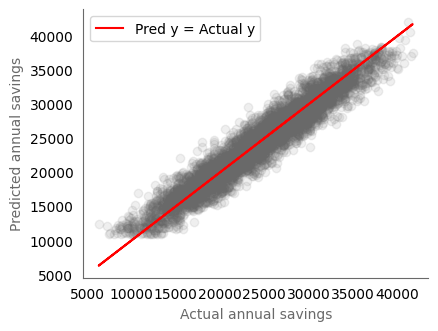

In [27]:
# Prediction diagnostics
fig, axes = plt.subplots(
    nrows=1, ncols=1, constrained_layout=True, figsize=(6.4/1.5, 4.8/1.5)
)
axes.tick_params(bottom=False, left=False)
axes.grid(False)
axes.spines[['top', 'right']].set_visible(False)
axes.spines[['left', 'bottom']].set_color('dimgray')

axes.scatter(
    y_test, y_pred, color='dimgray', alpha=0.1
)
axes.plot(
    y_test, y_test, color='red', label='Pred y = Actual y'
)
axes.set_xlabel('Actual annual savings', fontsize=10, color='dimgray')
axes.set_ylabel('Predicted annual savings', fontsize=10, color='dimgray')
axes.legend();

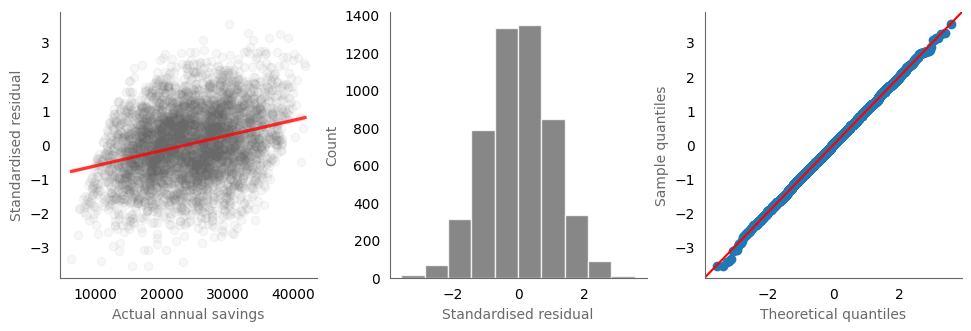

In [28]:
# Residual diagnostics
fig, axes = plt.subplots(
    nrows=1, ncols=3, constrained_layout=True, figsize=(6.4*1.5, 4.8/1.5)
)
axes = axes.flatten()

# Plot standardised residuals vs. observed values
sns.regplot(
    x=y_test, y=standardised_residuals, line_kws={'color': 'red', 'alpha': 0.75}, scatter_kws={'color': 'dimgray', 'alpha': 0.05}, ax=axes[0]
)
axes[0].set_xlabel('Actual annual savings', fontsize=10, color='dimgray')
axes[0].set_ylabel('Standardised residual', fontsize=10, color='dimgray')

# Plot histogram for standardised residuals
axes[1].hist(
    standardised_residuals, color='dimgray', alpha=0.8, edgecolor="white"
)
axes[1].set_xlabel('Standardised residual', fontsize=10, color='dimgray')
axes[1].set_ylabel('Count', fontsize=10, color='dimgray')

# Plot q-q plot for standardised residuals
sm.qqplot(
    standardised_residuals, line='45', ax=axes[2]
)
axes[2].set_xlabel('Theoretical quantiles', fontsize=10, color='dimgray')
axes[2].set_ylabel('Sample quantiles', fontsize=10, color='dimgray');

for ax in axes:
    ax.tick_params(bottom=False, left=False)
    ax.grid(False)
    ax.spines[['top', 'right']].set_visible(False)
    ax.spines[['left', 'bottom']].set_color('dimgray')

---------------------------

# Ethics

**Key questions:**

* Are there any ethical concerns with using any of the predictor variables in the dataset? Which variables, and why?

* Would you change the model to address these concerns? Does this change have a cost in terms of model performance?
  
* How would you balance performance against ethics?
  
* Which model would you finally decide to use to predict customer savings rates, and why?
  
* Is there anything else ethically questionable about the data?

## Background

### PCA

**1) Basic principle**

1. Factorising the covariance matrix gives eigenvectors

2. Eigenvectors are directions in the feature space along which data varies

3. A principal components is formed by projecting data points onto an eigenvector

4. Eigenvalues are proportional to the variance of data along a principal component

5. By only using a subset of the principal components, dimensionality is reduced

    *Principal components are independent as eigen vectors are orthogonal*

---------------

**2) Implementation**

**_1. Z-score standardise data_**

* PCA can be sensitive to scale & variance of features

**_2. Compute covariance matrix_**

$C=X^TX$

*Where $C$ is the $p\times p$ covariance matrix, $X^T$ is the $p \times n$ transpose of the design matrix $X$ (itself $n \times p$)*

**_3. Factorise covariance matrix using SVD_**

$C = U\Sigma V^T$

*Where each column in $U$ is an eigenvector with $p$ elements and $\Sigma$ is a diagnol matrix containing corresponding singular values*

**_4. Normalise the eigenvectors_**

$U_{i_{norm}}= \frac{U_i}{||U_i||}$

*Divide by the euclidian norm*

**_5. Compute eigen values_**

$\lambda_i = \sigma_i^2$

*Where $\sigma_i$ are the singular values in the diagnol matrix $\Sigma$*

**_6. Assess normalised eigen vectors_**

* *Loadings* are the $p$ elements in a normalised eigenvector $U_{i_{norm}}$

* They indicate the relative contribution of each feature to the $ith$ principal component

* A larger loading indicates a more significant contribution
  
**_7. Choose $k$ principal components_**

* An eigen value is proportional to the variance of data along a principal component

* Calculate the proportion of variance explained by a principal component:

    $\frac{\lambda_i}{\sum_{i=1}^p \lambda_i}$

    *Where the denominator is the total variance along the principal components*

* Sort eigenvalues in descending order

* Choose $k$ principal components based on the cumulative % of variance explained
  
**_8. Transform new data_**

* A data point is transformed onto a principal component via a dot product with the corresponding eigen vector:

    $x_{Projection} = U_i^TX$

  *Where $x_{Projection}$ is a scalar, $U_i$ is an eigen vector with $p$ loadings and $X$ is a vector with $p$ elements*

* In matrix form:

    $\boldsymbol{X}_{Projection} = \boldsymbol{U}^T\boldsymbol{X}$

  *Where $\boldsymbol{X}_{Projection}$ is an $n \times k$ matrix,  $\boldsymbol{X}$ is an $n \times p$ matrix and $\boldsymbol{U}$ is a matrix containing $k$ eigen vectors with $p$ elements each*

--------------------

### Diagnosing multicollinearity

**_a) Eigen values of the covariance matrix_**

*"The smallest eigenvalue is 1.53e-16. This might indicate that there are strong multicollinearity problems or that the design matrix is singular."*

* Each eigenvalue indicates the variance of the data along the direction of the corresponding eigenvector.

* Eigenvalues close to $0$ indicate multicollinearity:

**_b) Condition index_**

* Used to assess multicollinearity

* Utilises magnitude of variance along orthogonal eigen vectors in the feature space (as given by eigen values)

    $\text{Condition index} = \sqrt{\frac{\lambda_{max}}{\lambda_{min}}}$

    *Where $\lambda_{max}$ is the largest eigen value and $\lambda_{min}$ is the smallest.*

* Intepretation:

    $\text{Condition index} = 1:$ -> *Eigen values similar in size - no multicollinearity*

    $\text{Condition index} > 30:$ -> *Large disparity in size - multicollinearity*

---------------

## Summary

**1) Are there any ethical concerns with using any of the predictor variables in the dataset? Which variables, and why?**

* As the model is trained using personal information, the development process and any decisions made using the model must comply with data protection laws. This means data privacy should be prioritised, and data processing should be transparent (with informed consent). Additionally, since some of the predictive variables are protected characteristics, obligations under the Equality Act must be considered. For instance, it may be necessary to omit protected characteristics from model training if using them may lead to discrimination. 

* Specific concerns are highlighted below:

    1. **_Age_**
       
        * Variables: age, age_dummy_2, age_dummy_3, age_interaction_1 & age_interaction_2
          
        * Age is a protected characteristic. The risk of age-based discrimination should therefore be considered.
          
    2. **_Credit score & savings balance_**
       
        * Variables: credit_score, savings_bal_lbg & savings_bal_interaction
          
        * These features should be handled with care to protect individuals' financial privacy. Furthermore, care must be taken to avoid unfairly targeting financially vulnerable individuals.
          
    3. **_Housing spend_**
    
        * Variable: housing_spend
       
        * Analysing housing spending may raise concerns if it leads to discriminatory practices, such as denying housing opportunities based on certain spending patterns.
          
    5. **_Ethnicity_**
    
        * Variable: ethnicity_group_South Asian
       
        * Ethnicity is a protected characteristic. The risk of discrimination should therefore be considered.

**2) Would you change the model to address these concerns? Does this change have a cost in terms of model performance?**

* Data privacy concerns could be addressed by anonymising data early in the development process using Principal Component Analysis (PCA). Unfortunately, the loss of information associated with PCA might negatively affect model performance. Furthermore, predictions may be less interpretable.

* Depending on the purpose of the model, protected characteristics (and variables correlated with these features) may need to be omitted to avoid unfair discrimination. This may negatively impact model performance.

* It might also be necessary to increase representation for certain groups in the training data.

**3) How would you balance performance against ethics?**

* As an individual, I would stay informed about emerging ethical guidelines and best practices in the field. Before beginning model development, an effective impact assessment could then be conducted to evaluate the risks to individuals' rights under data protection and discrimination laws. The development process would also be clearly documented, with alternative approaches with fewer ethical concerns prioritised. Additionally, explainable models would be prioritised to ensure that data processing and subsequent decisions can be clearly communicated.

**4) Which model would you finally decide to use to predict customer savings rates, and why?**

* In this instance, the ridge regression model is preferable from several perspectives. Firstly, it outperforms the random forest model on both R-squared and mean absolute error. Secondly, if transparency is crucial, ridge regression is more explainable than a random forest. Next, as linear regression models are less complex, they may be less prone to capturing subtle biases in the data and therefore unintended discrimination. Finally, linear regression models are computationally less intensive than random forests.

**5) Is there anything else ethically questionable about the data?**
* Given the data is at individual level, robust security measures must be in place to prevent unauthorised access and misuse. 